### Gene2Vec Experiments
Attempting to recreate results of [gene2vec paper](https://doi.org/10.1186/s12864-018-5370-x)

1. [Import known gene pathways from MSigDB](#pathways)
2. [Generate pairs of genes from gene pathway sets](#pairs)
3. [Use `gensim` to train with gene2vec](#gensim)
4. [Visualise embeddings with PCA and tSNE](#vis)
5. [Load and preprocess somatic mutations from TCGA in BigQuery](#tcga)
6. [Produce 2D images for every sample](#2d)
7. [Model Training](#training) 
    - 7.1 [7.1 Ensemble of sklearn models on flat data (baseline on sparse samples)](#sklearn)
    - 7.2 [Random Forest on images](#rf)
    - 7.3 [ResNet50 w ImageNet weight initialisation (FastAI)](#fastai)

#### 0. Initialisation, Imports, Environment Variables
<a id="pathways"></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import io, os, sys, time, datetime, math, random

# dataproc
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt, matplotlib.image as img

# gene2vec
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from multiprocessing import Pool

# pytorch and fastai
from fastai import *
from fastai.vision import *
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

In [3]:
## word2vec parameters
W2V_DIMENSION   = 256   # dimension of the embedding
W2V_NUM_WORKERS = 96    # number of worker threads
W2V_MIN_COUNT   = 1     # ignores all words with total frequency lower than this
W2V_SG          = 1     # sg =1, skip-gram, sg =0, CBOW
W2V_N_ITER      = 10    # number of iterations
W2V_WINDOW_SIZE = 1     # The maximum distance between the gene and predicted gene within a gene list
W2V_NEGATIVE    = 3     # number of negative samples

# Environment variables
MSIGDB          = '../../data/gene2vec/msigdb.v6.2.symbols.gmt'
GENE_PAIRS      = '../../data/gene2vec/gene_pairs_set.pkl'
GENE2VEC_DIR    = '../../models/gene2vec/'
TCGA            = '../../data/tcga/processed_somatic_mutations_subset.csv'
INTOGEN         = '../../data/drivers/intogen-drivers-data.tsv'
EXP1_DIR        = '../../models/sklearn-ensemble/'
FIGURES         = '../../figures/'

In [4]:
# Helper functions #

def size(obj, suffix='B'):
    """
    Get the size of provided object in human readable format.
    """
    import sys
    num = sys.getsizeof(obj)
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def freememory():
    """
    Run garbage collection to free up memory.
    """
    import gc
    gc.collect()

#### 1. Import known gene pathways from [MSigDB](http://software.broadinstitute.org/gsea/msigdb/collections.jsp)
<a id="pathways"></a>

In [5]:
def _get_data(line):
    """
    Read pathway name and set of genes from each line, parsing gene appropriately.
    """
    name, _, genes = line.split("\t", 2)
    return name, set(gene.replace('\n', '') for gene in genes.split("\t"))

def load_msigdb():
    """
    Read msigdb pathways file line by line and parse into useful dataframe.
    """
    with open(MSIGDB, 'r') as fp:
        pathways_df = pd.DataFrame(data=[_get_data(line) for line in fp],
                                   columns=["name", "set"])
        
    return pathways_df

In [51]:
?sns.kdeplot

Signature:
sns.kdeplot(
    data,
    data2=None,
    shade=False,
    vertical=False,
    kernel='gau',
    bw='scott',
    gridsize=100,
    cut=3,
    clip=None,
    legend=True,
    cumulative=False,
    shade_lowest=True,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    **kwargs,
)
Docstring:
Fit and plot a univariate or bivariate kernel density estimate.

Parameters
----------
data : 1d array-like
    Input data.
data2: 1d array-like, optional
    Second input data. If present, a bivariate KDE will be estimated.
shade : bool, optional
    If True, shade in the area under the KDE curve (or draw with filled
    contours when data is bivariate).
vertical : bool, optional
    If True, density is on x-axis.
kernel : {'gau' | 'cos' | 'biw' | 'epa' | 'tri' | 'triw' }, optional
    Code for shape of kernel to fit with. Bivariate KDE can only use
    gaussian kernel.
bw : {'scott' | 'silverman' | scalar | pair of scalars }, optional
    Name of reference method to det

In [6]:
pathways_df = load_msigdb()

(-10, 400)

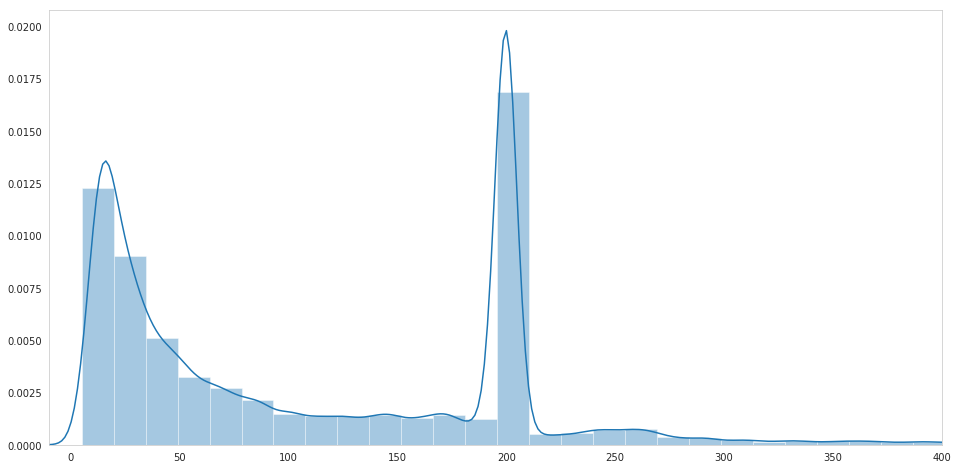

In [81]:
data = pathways_df['set'].apply(lambda x: len(x)).sort_values(ascending=False).values
import numpy as np; import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
plt_ = sns.distplot(np.array(data), bins=200, kde_kws={"kernel":"gau", "bw":"5", "gridsize":2000})
plt_.grid(False)
ax = plt_.axes; ax.set_xlim(-10,400)
fig.savefig("../../figures/pathways_dist.png")

In [86]:
pathways_df['set']

0        {RAB10, CACNG3, RRS1, MAML3, SNX25, ACTB, FOXN...
1        {EFNA1, DIDO1, VKORC1L1, B4GALT6, C11orf92, HG...
2        {CHRNG, PLXNC1, TNFRSF21, KAZALD1, EFNA1, C1QC...
3        {SHCBP1L, EFNA1, C1QC, TMEM105, GRB2, EPHB6, V...
4        {ERBB4, NR3C2, PRPF38B, ALDH6A1, ZIC4, BHLHE40...
5        {PDIA3, CLIC1, PCSK4, NTN3, MAPRE3, NUDT3, RGS...
6        {CACNG3, SEC24B, PRKAG2, ST3GAL1, TSEN54, GRRP...
7        {TIMP2, IGJ, HS3ST5, ZIC4, MYH6, TBC1D16, DPYS...
8        {RPL28, ESRRA, PRKAG2, MTPN, GPA33, PRDM1, NCK...
9        {RAB10, ADAM10, SIX4, MYADM, NOL4, NFE2L1, PAC...
10       {PDHA2, IL17B, KLF14, ACCN1, CREB5, SENP1, VAM...
11       {DCTN1, ZFY, GTF2A1, NCALD, SEC62, MBNL2, SIK2...
12       {PRRX1, HOXD4, UNC5C, SYNPO2L, EMX2, COLEC10, ...
13       {DNMT1, ECEL1, ARID4A, HIST1H2AM, ALDH6A1, AP1...
14       {MYL12A, C3orf19, GGT7, IMP3, PRKAG2, MTPN, C1...
15       {RASGRF1, TIMP2, PANK1, MRPS23, ARAP2, SIPA1L1...
16       {C3orf19, GPN2, ARF3, BCDIN3D, PRKAG2, PPIL1, .

#### 2. Generate pairs of genes from gene pathway sets
<a id="pairs"></a>

In [83]:
def generate_gene_pairs(gene_set):
    """
    Get gene pairs
    """
    from itertools import combinations
    # Get all combinations of length 2 
    pairs = combinations(list(gene_set), 2)
    return set(pairs)

def get_pairs_set(df):
    """
    Return the set union of all pairs from every gene set within the df.
    """
    return set.union(*df['pairs'].tolist())

def load_pairs():
    """
    If gene pairs file exists, load it. Otherwise, create it and save to gene pairs file.
    """
    if os.path.isfile(GENE_PAIRS):
        print("Reading gene pairs file.")
        with open (GENE_PAIRS, 'rb') as f:
            gene_pairs = pkl.load(f)
    else:
        print("Creating new gene pairs file.")
        pathways_df['pairs'] = (pathways_df.set
                                           .apply(generate_gene_pairs))
        gene_pairs = pathways_df.pipe(get_pairs_set)

        with open (GENE_PAIRS, 'wb') as f:
            pkl.dump(gene_pairs, f)
            
    return gene_pairs

In [84]:
%%time
gene_pairs = load_pairs()

Reading gene pairs file.


KeyboardInterrupt: 

In [12]:
len(gene_pairs)

144603456

In [ ]:
freememory()

#### 3. Use [`gensim`](https://radimrehurek.com/gensim/models/word2vec.html) to train with gene2vec
<a id="gene2vec"></a>
- With a c compile installed `gensim` offers a [70x speedup compared to plain NumPy implementation](https://rare-technologies.com/parallelizing-word2vec-in-python/)

In [ ]:
def train_word2vec(gene_pairs, dimension=W2V_DIMENSION):
    """
    Trains n_iter iterations of word2vec and saves model on each iteration.
    """
    # initialise and save model
    model = gensim.models.Word2Vec(gene_pairs, 
                                   size=dimension,
                                   window=W2V_WINDOW_SIZE, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=W2V_NUM_WORKERS, 
                                   negative=W2V_NEGATIVE,
                                   sg=W2V_SG)
    print("gene2vec model initialised")
    
    current_iter = 0
    filename = 'dim_{}/iter_{}'.format(dimension, current_iter)
    
    model.save(GENE2VEC_DIR + filename)
    print("gene2vec model saved")
    del model 
    
    # train model
    for current_iter in range(1,W2V_N_ITER+1):
        loadfile = 'dim_{}/iter_{}'.format(dimension, current_iter - 1)
        
        # shuffle pairs
        random.shuffle(gene_pairs)
        
        # load model and train on shuffled gene pairs
        model = gensim.models.Word2Vec.load(GENE2VEC_DIR + filename)
        model.train(gene_pairs,total_examples=model.corpus_count,epochs=model.iter)
        
        # save trained model
        savefile = 'dim_{}/iter_{}'.format(dimension, current_iter)
        model.save(GENE2VEC_DIR + savefile)
        print("gene2vec dimension " + str(dimension) + " iteration " + str(current_iter) + " saved")
        del model
        
def train_word2vec_gridsearch(gene_pairs):
    """
    Trains a gridsearch (entirety of provided parameter space) of different
    word2vec models, and saves in directory tree.
    """
    dims = [16, 32, 64, 128, 256, 512, 1024]
    
    for dim in dims:
        train_word2vec(gene_pairs, dim)

In [ ]:
train_word2vec_gridsearch(list(gene_pairs))

#### 4. Visualise embeddings with PCA and tSNE
<a id="vis"></a>

In [87]:
# load model and train on shuffled gene pairs

filename = GENE2VEC_DIR + 'dim_256/iter_9'

In [88]:
def load_embeddings(file_name):
    model = KeyedVectors.load(file_name)
    wordVector = model.wv
    vocabulary, wv = zip(*[[word, wordVector[word]] for word, vocab_obj in wordVector.vocab.items()])
    
    return np.asarray(wv), vocabulary

In [89]:
# load test file
wv, vocabulary = load_embeddings(filename)

# shuffle index of genes
indexes = list(range(len(wv)))
random.shuffle(indexes)

topN = len(wv) # for now select all genes
wv.shape
rdWV = wv[indexes,:,]
rdVB = np.array(vocabulary)[indexes][:topN]

(32479, 256)

In [90]:
print(wv.shape, rdWV.shape, rdVB.shape)

(32479, 256) (32479, 256) (32479,)


In [ ]:
def plot_2d(data, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('dimension 1', fontsize = 15)
    ax.set_ylabel('dimension 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    
    ax.scatter(data[:,0], data[:,1], s = 5, alpha=0.5)
    ax.grid()

# 2 component PCA visualisation
pca_2 = PCA(n_components=2)
pca_2.fit(rdWV)
pca_rdWV_2=pca_2.transform(rdWV)

# plot
plot_2d(pca_rdWV_2, title='2 Component PCA')

In [ ]:
# 50 component PCA for tSNE
pca = PCA(n_components=10)
pca.fit(rdWV)
pca_rdWV=pca.transform(rdWV)

n_iters = [100,500,1000]
# n_iters = [100,500,1000,10000,100000]

def tsne_worker(n_iter):
    """
    TSNE Worker, will run for CPU or GPU.
    """
    tsne = TSNE(n_components=2, 
                perplexity=30, 
                n_iter=n_iter, 
                learning_rate=200, 
                n_jobs=8)
    
    print('n_iter = {0:d} started'.format(n_iter))
    data = tsne.fit_transform(pca_rdWV)
    print('n_iter = {0:d} finished'.format(n_iter))
    return data, n_iter

import torch
cuda = torch.cuda.is_available()
if cuda:
    print("CUDA available, using GPU TSNE")
    from tsnecuda import TSNE
    for n_iter in n_iters:
        tsne = TSNE(n_components=2, 
                perplexity=30, 
                n_iter=n_iter, 
                learning_rate=200)
        data = tsne.fit_transform(pca_rdWV)
        plot_2d(data, '2D tSNE, n_iter={0:d}'.format(n_iter))    
else:
    print("CUDA not available, using multi-core TSNE")
    from MulticoreTSNE import MulticoreTSNE as TSNE
    
    p = Pool(4)

    # generate tsne of different iteration in parallel
    results = p.map(tsne_worker, [100, 500])

    # plot tSNE
    for data, n_iter in results:
        plot_2d(data, '2D tSNE, n_iter={0:d}'.format(n_iter))

---
#### 6. Produce 2D images for every sample
<a id="2d"></a>

For each sample, now want to encode gene2vec embeddings as a prior on mutation data.

In [128]:
df_X1.shape
df_X2.shape

def convert_to_onehot(df_in):
    """
    Convert count encoding to one-hot encoded representation of df.
    """
    df = df_in.copy()
    df[df != 0] = 1
    return df

def get_gene_intersection(df1, df2):
    """
    Get intersection of genes (features) from df1 and df2.
    """
    gene_intersection = []
    for gene in df1:
        if gene in df2.columns.tolist():
            gene_intersection.append(gene)

    return gene_intersection

    
def embed_gene_vectors(data_df, gene_df):
    """
    Matrix multiply somatic mutation data by gene embeddings and return batch of images.
    """
    samples = []
    for i, row in data_df.iterrows():
        # multiply gene embedding by bitwise mask taken from sample mutations
        embedded_sample = row.values * gene_df.values
        samples.append(embedded_sample)
    return np.dstack(samples)

def apply_spectral_clustering(data_df, onehot_df, num_clusters=25):
    """
    Determine a sorting on genes which creates visual structure.
    Calculates feature cooccurrence matrix, finds num_clusters as defined and sorts genes accordingly.
    """
    from sklearn.cluster import SpectralClustering
    c_matrix = onehot_df.T.dot(onehot_df) # cooccurrence matrix for genes in data source
    sc = SpectralClustering(num_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')
    clusters = sc.fit_predict(c_matrix)
    return data_df[:,np.argsort(clusters),:]
    
def visualise_sample(sample):
    """
    Visualise sample as image.
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(pd.DataFrame(sample), aspect='auto')
    # plt.colorbar()
    
def visualise_clusters(data_df, onehot_df, index=5000):
    """
    
    """
    # Initialise plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (18,12))
    fig.suptitle('TCGA Sample Number 5000')
    
    clustered1 = apply_spectral_clustering(data_df[:,:,index:index+1], 
                                           onehot_df, num_clusters=5)
    
    clustered2 = apply_spectral_clustering(data_df[:,:,index:index+1], 
                                           onehot_df, num_clusters=10)
    
    clustered3 = apply_spectral_clustering(data_df[:,:,index:index+1], 
                                           onehot_df, num_clusters=20)
    
    clustered4 = apply_spectral_clustering(data_df[:,:,index:index+1], 
                                           onehot_df, num_clusters=50)

    axes[0,0].imshow(pd.DataFrame(clustered1[:,:,0]), aspect='auto')
    axes[0,0].set(title='num_clusters=5')
    axes[0,1].imshow(pd.DataFrame(clustered2[:,:,0]), aspect='auto')
    axes[0,1].set(title='num_clusters=10')
    axes[1,0].imshow(pd.DataFrame(clustered3[:,:,0]), aspect='auto')
    axes[1,0].set(title='num_clusters=20')
    axes[1,1].imshow(pd.DataFrame(clustered4[:,:,0]), aspect='auto')
    axes[1,1].set(title='num_clusters=50')

(9539, 450)

(10106, 2361)

In [134]:
test = convert_to_onehot(df_X1)
test.values.shape

# load test file
wv, vocabulary = load_embeddings(filename)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocabulary)

genes = get_gene_intersection(test, df_genevec)
merge1 = test[genes]
merge2 = df_genevec[genes]

output = embed_gene_vectors(merge1, merge2)

(9539, 450)

In [ ]:
freememory()
clustered4 = apply_spectral_clustering(output, merge1, num_clusters=20)
size(clustered4)
visualise_sample(clustered4[:,:,5000])

In [ ]:
visualise_clusters(output, merge1, index=3000)
visualise_clusters(output, merge1, index=5000)

#### Image labelling and dataset creation

In [ ]:
# Absurdly, necessary image processing functions to create FastAI accepted dataset from 3D Numpy batches of images

def create_labels_df(df_y):
    """    
    Create labels df.
    """
    labels_df = (df_y4.copy()
                  .reset_index()
                  .rename(columns={'case_barcode':'name', 'project_short_name':'label'}))
    
    return labels_df
    

def create_labels_csv(labels_df, y_train, y_valid, savedir, img_format='png'):
    """
    Create labels.csv from labels df and knowledge of y_train and y_valid data splits.
    """
    train_labels = labels_df.loc[y_train.index]    
    valid_labels = labels_df.loc[y_valid.index]
    
    def format_name(name, label, split):
        return '{}/{}/{}.{}'.format(split, label, name, img_format)
    
    train_labels['name'] = train_labels.apply(lambda row: format_name(row['name'], row['label'], 'train'), axis=1)
    valid_labels['name'] = valid_labels.apply(lambda row: format_name(row['name'], row['label'], 'valid'), axis=1)

    pd.concat([train_labels, valid_labels]).to_csv(savedir + 'labels.csv', index=False)


def generate_dataset(X, y, data_base='../data/genevec_images/', test_size=0.2):
    """
    Generate image dataset folder structure as per MNIST and other common image datasets.
    """
    
    # Create labels df from y
    labels_df = create_labels_df(y)
    y_ = labels_df['label']
    
    print('Getting train/test/val split:')
    # 80/10/10 train test validation
    X_train, X_other, y_train, y_other = train_test_split(X, y_, test_size=test_size, 
                                                          random_state=42, stratify=y_)
    
    X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.5,
                                                        random_state=42, stratify=y_other)
    
    # Save all data to data directory
    data_dir = '{}{}'.format(data_base, time.strftime("%Y%m%d-%H%M%S"))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
        
    # Create labels.csv from y_train, y_valid
    create_labels_csv(labels_df, y_train, y_valid, savedir=data_dir + '/')
    
    dirs = ('train', 'valid', 'test')
    ys = (y_train, y_valid, y_test)
    Xs = (X_train, X_valid, X_test)

    for i, dir_ in enumerate(dirs):
        path = data_dir + '/' + dir_
        if not os.path.exists(path):
            os.mkdir(path)
        if (dir_ == 'test'):
            for j, row in enumerate(ys[i]):
                image_name = '{}.png'.format(labels_df.loc[ys[i].index[j]]['name'])
                img_path = path + '/' + image_name
                img.imsave(img_path, Xs[i][j,:,:])
        else:
            for label in set(ys[i].values):
                path_ = path + '/' + label
                if not os.path.exists(path_):
                    os.mkdir(path_)
                for j, row in enumerate(ys[i]):
                    if row == label:
                        image_name = '{}.png'.format(labels_df.loc[ys[i].index[j]]['name'])
                        img_path = path_ + '/' + image_name
                        img.imsave(img_path, Xs[i][j,:,:])

In [ ]:
clustered_df = apply_spectral_clustering(output, merge1, num_clusters=20)

df_X4 = clustered_df.transpose()
df_y4 = df_y1

df_X4.shape
df_y4.shape

generate_dataset(df_X4, df_y4)

---
##### 7.2 Random Forest on images
<a id="rf"></a>

In [124]:
models3 = {
        'dt' : {
            'model' : DecisionTreeClassifier()
        },
    
        'rf' : {
            'model' : RandomForestClassifier(n_estimators=10, 
                                             min_samples_leaf=2,
                                             min_samples_split=17, 
                                             criterion='gini', 
                                             max_features=8)
        },
    
        'gbt' : { 
            'model' : GradientBoostingClassifier(n_estimators=20, 
                                                 min_samples_leaf=2,
                                                 min_samples_split=17, 
                                                 max_features=20)
        }
    }

In [133]:
# flatten images to sparse feature vectors
img_flattened = output.reshape(-1, output.shape[-1])
img_flattened.shape

NameError: name 'output' is not defined

In [ ]:
df_X3 = img_flattened.transpose()
df_y3 = df_y1

for name, model in models3.items():
    model['train_pred'], model['acc_cv'], model['cv_proba'] = run_model(df_X3, df_y3, model['model'], name, 'df_3')
    plot_confusion_matrix(df_y1, 
                          model['train_pred'], 
                          classes=df_y1['project_short_name'].value_counts().index.values)

##### 7.3 ResNet50 w ImageNet weight initialisation (FastAI)
<a id="fastai"></a>

In [ ]:
bs = 32

In [ ]:
data = (ImageList.from_folder('../data/genevec_images/20190522-075618/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .transform(size=512)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(10,8))

In [ ]:
freememory()

In [ ]:
def freegpu(data, model):
    del data
    del model
    freememory()
    torch.cuda.empty_cache()
    
freegpu(data, learn)

In [ ]:
## To create a ResNET 50 with pretrained weights
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=ShowGraph)
learn.fit_one_cycle(10)
learn.save('stage-1-256')

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-2))

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

---

In [ ]:
for word in vocabulary:
    if '\n' in word:
        print(word)